In [100]:
import glob
from timeit import default_timer as timer

import torch
import clip
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.special

In [101]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [102]:
# CONSTANTS
"""
Choose accordingly to the Model/Dataset being evaluated:
MODEL= {ViT-B-32, ViT-B-16, RN50, RN101, ViT-L-14, RN50x16} 
DATASET= {derm7pt}
"""

MODEL = "RN50"
DATASET = "derm7pt"
ADDITIONAL_COMMENTS = "CLASS_LABELS_PROMPTS"

In [103]:
CLASS_LABELS_PROMPTS = {
    "Melanoma": ["This is dermatoscopy of melanoma"],
    "Nevus": ["This is dermatoscopy of nevus"]
}

In [104]:
REFERENCE_CONCEPT_PROMPTS = ["This is dermatoscopy"]

In [105]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):
    """
    Similarity Score used in "Fostering transparent medical image AI via an image-text foundation model grounded in medical literature"
    https://www.medrxiv.org/content/10.1101/2023.06.07.23291119v1.full.pdf
    """

    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [106]:
print(f"[INFO] DATASET: {DATASET}")
print(f"[INFO] MODEL: {MODEL}")
SEED = 42

# Load image embeddings 
#img_embeddings = np.load(f"img_embeddings/derm7pt/image_embeddings_{DATASET}_{MODEL}-Fine-Tuned_{SEED}_Segmented_Norm.npy", allow_pickle=True).item()
img_embeddings = np.load(f"output/{MODEL}/image_embeddings/image_embeddings__derm7pt_{MODEL}-Fine-Tuned_{SEED}.npy", allow_pickle=True).item()

# Load reference embeddings
#reference_embeddings = torch.from_numpy(np.load(f"reference_embeddings/derm7pt/reference_embeddings_{DATASET}_{MODEL}-Fine-Tuned_{SEED}.npy")).unsqueeze(0)
reference_embeddings = torch.from_numpy(np.load(f"output/{MODEL}/text_embeddings/reference_embeddings__derm7pt_{MODEL}-Fine-Tuned_{SEED}.npy")).unsqueeze(0)

results = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)

    similarity_scores = []
    for disease_label in CLASS_LABELS_PROMPTS.keys():
        # Load text embeddings
        #text_feats = torch.from_numpy(np.load(f"text_embeddings/derm7pt/class_label_embeddings_{disease_label}_{DATASET}_{MODEL}-Fine-Tuned_{SEED}.npy")).unsqueeze(0)
        text_feats = torch.from_numpy(np.load(f"output/{MODEL}/text_embeddings/class_label_embeddings_{disease_label}_derm7pt_{MODEL}-Fine-Tuned_{SEED}.npy")).unsqueeze(0)
        
        # Calculate similarity
        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=-1,
                                                temp=(1/np.exp(4.5944)),
                                                normalize=False)

        similarity_scores.append(similarity[0])

    # Save score into a dictionary w.r.t. to image
    results[im] = similarity_scores

[INFO] DATASET: derm7pt
[INFO] MODEL: RN50


In [107]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc

if DATASET == "PH2":
    gt = pd.read_csv("../data/PH2_dataset.csv")
    
    train_images_df = pd.read_csv("../data/PH2_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/PH2_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/PH2_test.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "derm7pt":
    gt = pd.read_csv("../data/derm7pt/image_classes_derm7pt.csv")
    
    train_images_df = pd.read_csv("../data/derm7pt/derm7pt_train_seg.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/derm7pt/derm7pt_validation_seg.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/derm7pt/derm7pt_test_seg.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "ISIC_2018":
    gt = pd.read_csv("../data/image_classes_ISIC_2018.csv")
    
    train_images_df = pd.read_csv("../data/ISIC_2018_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("../data/ISIC_2018_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("../data/ISIC_2018_test.csv")
    test_images = test_images_df["images"].tolist()

y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        if DATASET == "ISIC_2018":
            y_true_val.append(1 if gt.loc[gt['images'] == str(im)]['labels'].tolist()[0] == 3 else 0)
        else:
            y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(np.max(results[im]))

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold, "\n")

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        if DATASET == "ISIC_2018":
            y_true.append(1 if gt.loc[gt['images'] == str(im)]['labels'].tolist()[0] == 3 else 0)
        else:
            y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(1 if np.max(results[im]) > optimal_threshold else 0)
        y_pred_probs.append(np.max(results[im]))


print("y_true: ", y_true)
print("y_pred: ", y_pred)

print(f"Classification Report:")
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=["NEV", "MEL"]))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

print(f"Confusion Matrix:")
print(conf_matrix,"\n")

# Calculate AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# BACC
bacc = balanced_accuracy_score(y_true, y_pred)
print(f"BACC: {bacc}")

# Sensitivity
SE = TP / (TP + FN)
print(f"Sensitivity: {SE}")

# Specificity
SP = TN / (TN + FP)
print(f"Specificity: {SP}")

Threshold value is: 0.14601976 

y_true:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

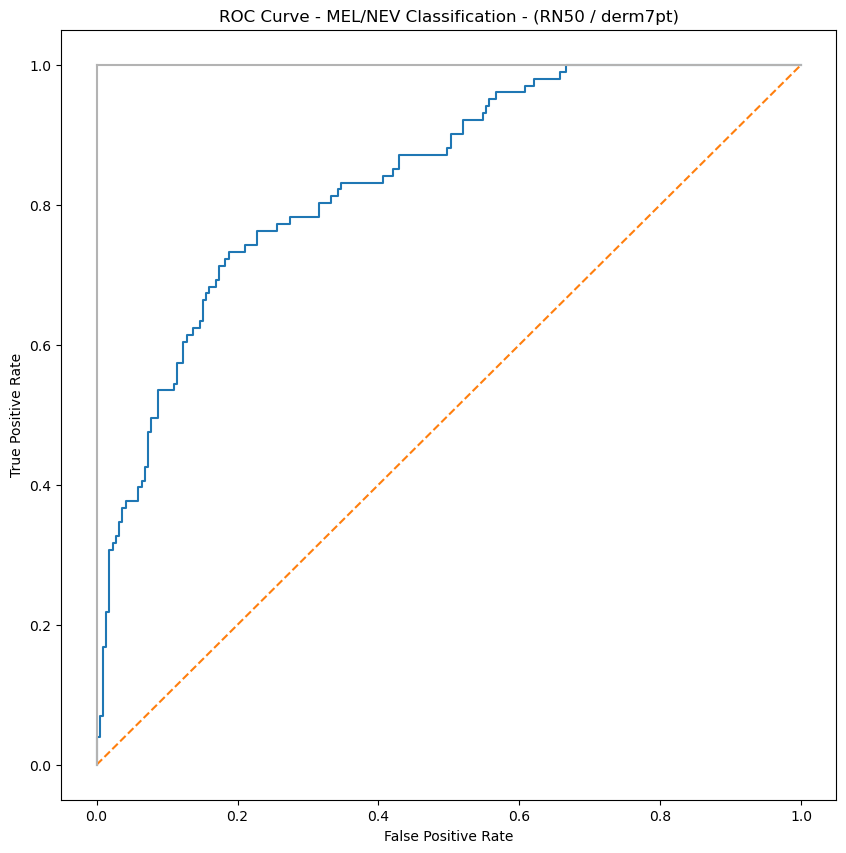

In [108]:
# Plot ROC AUC curve
import matplotlib.pyplot as plt

plt.subplots(1, figsize=(10,10))
plt.title(f'ROC Curve - MEL/NEV Classification - ({MODEL} / {DATASET})')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()